# Rdkit 化学反应高级功能

## 引入所需库

In [1]:
#! /usr/bin/python
# coding: utf-8

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

from rdkit.Chem import Recap
from rdkit.Chem import BRICS


## 保护原子
以酰胺反应为例 ， 反应物分子1中含有一个 - COOH ， 另一个分子中含有两个 - NH 。 之后定义反应模板 ， 然后让其反应 。

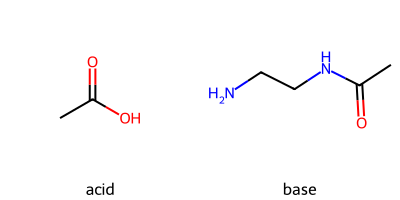

In [2]:
acid = Chem.MolFromSmiles('CC(=O)O')
base = Chem.MolFromSmiles('CC(=O)NCCN')
mols = [acid, base]
img = Draw.MolsToGridImage(
    mols,
    molsPerRow=2,
    subImgSize=(200, 200),
    legends=['acid', 'base']
)
img


In [4]:
rxn = AllChem.ReactionFromSmarts('')
rxn = AllChem.ReactionFromRxnFile(
    './data/AmideBond.rxn')
ps = rxn.RunReactants(acid, base)
print('the num of reactions', len(ps))

for reaction in ps:
    reactions_smi = Chem.MolToSimiles(reaction)
    print('this reaction is', reactions_smi)


ArgumentError: Python argument types in
    ChemicalReaction.RunReactants(ChemicalReaction, Mol, Mol)
did not match C++ signature:
    RunReactants(RDKit::ChemicalReaction* self, boost::python::list reactants, unsigned int maxProducts=1000)
    RunReactants(RDKit::ChemicalReaction* self, boost::python::tuple reactants, unsigned int maxProducts=1000)

## 把分子切成片段
### Recap方法
Recap方法通过模拟实验室中常用的化学反应，将反应分子分解成功合理的片段
Recap 方法返回的是类似于node tree结构的数据。

> 注：分子片段的Smiles前面通常会加一个* 如 ‘*c1ccccc1’

In [5]:
m = Chem.MolFromSmiles('c1ccccc1OCCOC(=O)CC')
hierarch = Recap.RecapDecompose(m)
type(hierarch)

# 层次结构的原始分子
print('smi=', hierarch.smiles)  # smi= CCC(=O)OCCOc1ccccc1

# 每个节点使用smiles键控的字典跟踪其子节点
ks = hierarch.children.keys()
print(sorted(ks))
# ['*C(=O)CC', '*CCOC(=O)CC', '*CCOc1ccccc1', '*OCCOc1ccccc1', '*c1ccccc1']


smi= CCC(=O)OCCOc1ccccc1
['*C(=O)CC', '*CCOC(=O)CC', '*CCOc1ccccc1', '*OCCOc1ccccc1', '*c1ccccc1']


### BRICS方法

RDKit 还提供了另一种把分子切成片段的方法——BRICS方法。 BRICS方法主要是根据可合成的的键对分子进行切断，因此其返回的数据结构是来自于该分子的不同分子片段， 虚拟原子（*）是告诉我们是如何切断的。


对下图中的分子进行BRICS分解

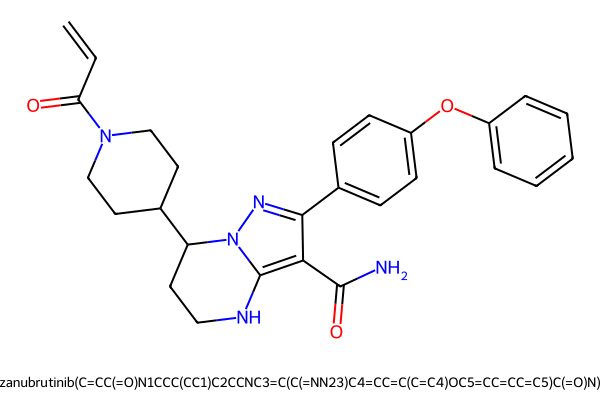

In [6]:
smi = 'C=CC(=O)N1CCC(CC1)C2CCNC3=C(C(=NN23)C4=CC=C(C=C4)OC5=CC=CC=C5)C(=O)N'
m = Chem.MolFromSmiles(smi)
Draw.MolToImage(
    m,
    size=(600, 400),
    legend='zanubrutinib(C=CC(=O)N1CCC(CC1)C2CCNC3=C(C(=NN23)C4=CC=C(C=C4)OC5=CC=CC=C5)C(=O)N)'
)


{'[3*]O[3*]', '[6*]C(N)=O', '[16*]c1ccc([16*])cc1', '[5*]N1CCC(C2CCNc3c([16*])c([14*])nn32)CC1', '[16*]c1ccccc1', '[1*]C(=O)C=C'}


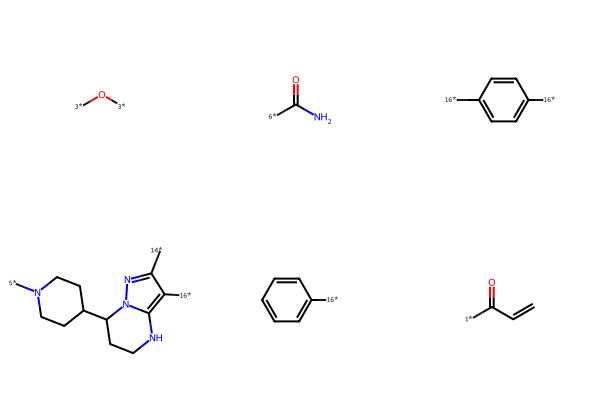

In [7]:
frags = (BRICS.BRICSDecompose(m))
print(frags)

mols = []
for fsmi in frags:
    mols.append(Chem.MolFromSmiles(fsmi))

img = Draw.MolsToGridImage(
    mols,
    molsPerRow=3,
    subImgSize=(200, 200),
    legends=['' for x in mols]
)
img

## 组合分子片段–BRICS方法
以上述片段进行BRICS组合产生分子

新分子数： 76


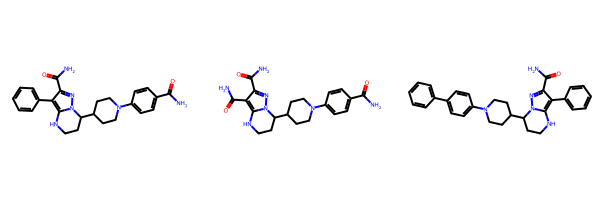

In [8]:
newms = BRICS.BRICSBuild(mols)
newms = list(newms)
print('新分子数：', len(newms))  # 新分子数： 76（含少量化学结构不合理的结构）

mols = [newms[0], newms[1], newms[2]]
img = Draw.MolsToGridImage(
    mols,
    molsPerRow=3,
    subImgSize=(200, 200),
    legends=['' for x in mols]
)
##可视化前3个结构
img

## 自定义片段生成方法
除了上面提到的自动片段分解方法，RDKit提供了更灵活的函数可根据用户定义的键进行切断产生片段。    
比如对所有环上的原子和非环上的原子组成的键进行进行切断。

((2, 4), (25, 22), (25, 26), (32, 15))
type= <class 'rdkit.Chem.rdchem.Mol'>


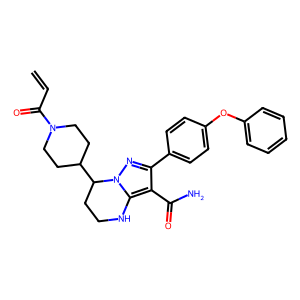

In [9]:
smi = 'C=CC(=O)N1CCC(CC1)C2CCNC3=C(C(=NN23)C4=CC=C(C=C4)OC5=CC=CC=C5)C(=O)N'
m = Chem.MolFromSmiles(smi)
submol = m.GetSubstructMatches(Chem.MolFromSmarts('[!R][R]'))
print(submol)  # ((2, 4), (25, 22), (25, 26), (32, 15))
bonds_id = [m.GetBondBetweenAtoms(x, y).GetIdx() for x, y in submol]

frags = Chem.FragmentOnBonds(m, bonds_id)
print('type=', type(frags))  # type= <class 'rdkit.Chem.rdchem.Mol'>
Draw.MolToImage(
    m,
    
)


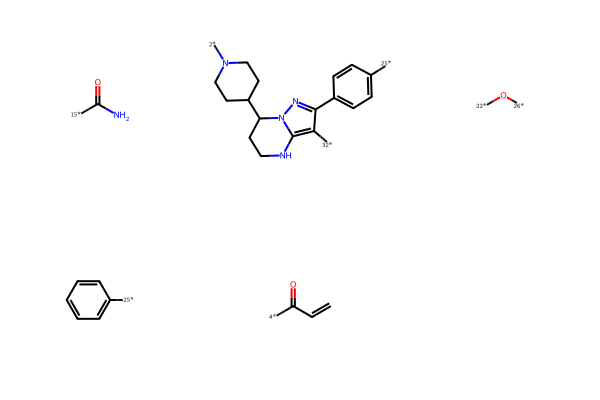

In [10]:
smis = Chem.MolToSmiles(frags)
smis = smis.split('.')
mols = []
for smi in smis:
    mols.append(Chem.MolFromSmiles(smi))

img = Draw.MolsToGridImage(
    mols,
    molsPerRow=3,
    subImgSize=(200, 200),
    legends=['' for x in mols]
)
img